In [71]:
#第一题：基于LeNet训练

In [72]:
#加载Fashion-MNIST数据集，抽取10%样本
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [73]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="E:/data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="E:/data", train=False, transform=trans, download=True)

In [74]:
# 获取原始训练集的子集
train_subset_indices = []
for label in range(10):
    label_indices = torch.where(mnist_train.targets == label)[0]
    num_samples = int(len(label_indices) * 0.1)
    train_subset_indices.extend(label_indices[:num_samples])

# 获取原始测试集的子集
test_subset_indices = []
for label in range(10):
    label_indices = torch.where(mnist_test.targets == label)[0]
    num_samples = int(len(label_indices) * 0.1)
    test_subset_indices.extend(label_indices[:num_samples])

# 构建训练集和测试集的子集
train_subset = data.Subset(mnist_train, train_subset_indices)
test_subset = data.Subset(mnist_test, test_subset_indices)

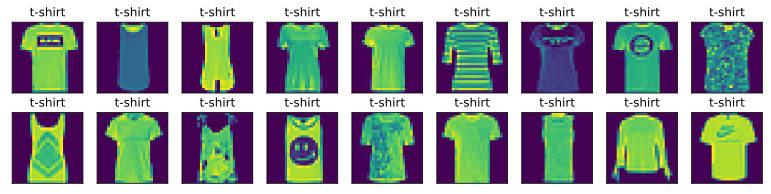

In [251]:
#以下是训练数据集中前几个样本的图像及其相应的标签。
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

d2l.use_svg_display()
X, y = next(iter(data.DataLoader(train_subset, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [246]:
test_subset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.2039, 0.7529, 0.4510, 0.1059, 0.0039, 0.0039, 0.1216,
           0.5608, 0.7020, 0.1255, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0196, 0.4431,
           0.7255, 0.8471, 0.7451, 0.8980, 0.9294, 0.8627, 0.8510, 0.9490,
           0.7882, 0.7490, 0.8706, 0.6549, 0.3412, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1961, 0.6863, 0.7608,
           0.7412, 0.7294, 0.7255, 0.7333, 0.7804, 0.7373, 0.7216, 0.7569,
           0.7255, 0.7373, 0.7176, 0.7333, 0.7569, 0.8235, 0.0588, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7804, 0.7608, 0.7098,
           0.7373, 0.7451, 0.7412, 0.7373, 0.7529, 0.7804, 0.7725, 0.7647,
           0.7529, 0.7490, 0.7373, 0.7216, 

In [75]:
batch_size = 256
train_iter = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [76]:
#用 LeNet 网络对 Fashion-MNIST 数据集进行训练

In [77]:
#本段代码来自《动手学习深度学习》
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [216]:
#本节代码来自《动手学习深度学习》
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 1.593, train acc 0.381, test acc 0.348
8306.5 examples/sec on cpu


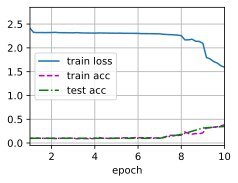

In [24]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
#下面修改batch_size

In [33]:
#修改batch_size
batch_size =128
train_iter = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

loss 2.305, train acc 0.094, test acc 0.100
7507.3 examples/sec on cpu


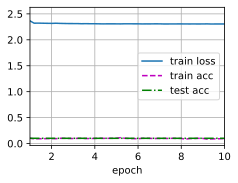

In [34]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [35]:
#修改batch_size
batch_size =64
train_iter = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

loss 1.769, train acc 0.316, test acc 0.454
6106.7 examples/sec on cpu


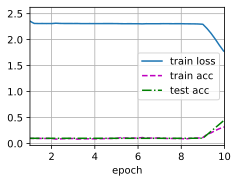

In [36]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [37]:
#修改batch_size
batch_size =32
train_iter = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

loss 0.759, train acc 0.707, test acc 0.703
5895.9 examples/sec on cpu


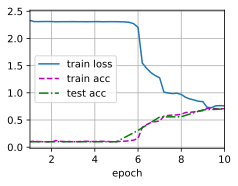

In [38]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [39]:
#修改batch_size
batch_size =16
train_iter = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

loss 0.528, train acc 0.793, test acc 0.771
4605.2 examples/sec on cpu


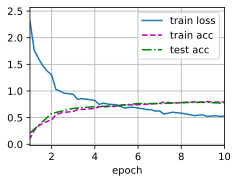

In [40]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [41]:
#修改batch_size
batch_size =8
train_iter = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

loss 0.469, train acc 0.818, test acc 0.808
2911.6 examples/sec on cpu


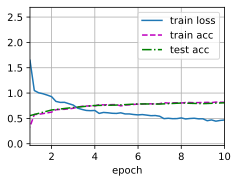

In [42]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [43]:
#修改batch_size
batch_size =4
train_iter = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

loss 0.500, train acc 0.812, test acc 0.819
1691.2 examples/sec on cpu


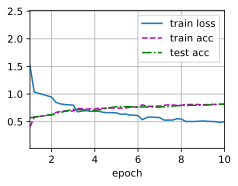

In [44]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [49]:
#修改batch_size
batch_size =2
train_iter = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

loss 0.717, train acc 0.730, test acc 0.705
1007.7 examples/sec on cpu


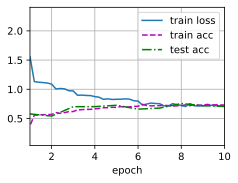

In [50]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [45]:
#修改batch_size
batch_size =512
train_iter = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

loss 2.319, train acc 0.102, test acc 0.100
8705.5 examples/sec on cpu


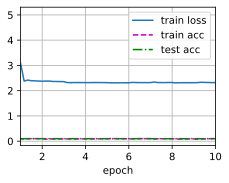

In [46]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [47]:
#修改batch_size
batch_size =1024
train_iter = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

loss 2.328, train acc 0.092, test acc 0.100
9522.0 examples/sec on cpu


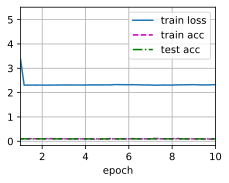

In [48]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [51]:
#可以看到，batch_size为8和4时效果较好，暂定batch_size为8，调整其它参数

In [86]:
#修改batch_size
batch_size =8
train_iter = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [87]:
#调整lr

loss 0.520, train acc 0.800, test acc 0.780
3145.1 examples/sec on cpu


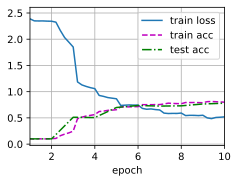

In [54]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.508, train acc 0.808, test acc 0.812
2715.8 examples/sec on cpu


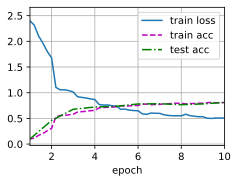

In [55]:
lr, num_epochs = 0.8, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.538, train acc 0.793, test acc 0.793
2839.7 examples/sec on cpu


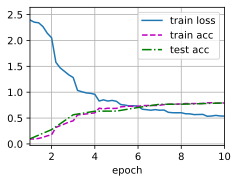

In [56]:
lr, num_epochs = 0.7, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.603, train acc 0.772, test acc 0.779
2733.4 examples/sec on cpu


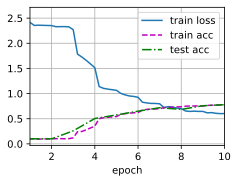

In [57]:
lr, num_epochs = 0.6, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [61]:
#0.7-0.9的学习率时效果较好，进一步调整

loss 0.516, train acc 0.804, test acc 0.735
3000.2 examples/sec on cpu


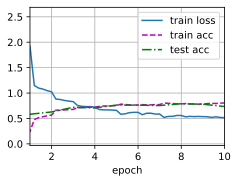

In [58]:
lr, num_epochs = 0.95, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.497, train acc 0.799, test acc 0.810
2831.1 examples/sec on cpu


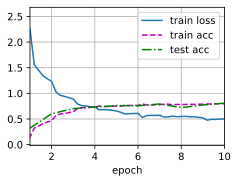

In [59]:
lr, num_epochs = 0.85, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.522, train acc 0.800, test acc 0.795
2733.9 examples/sec on cpu


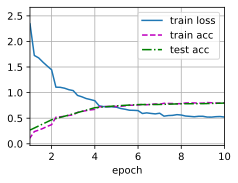

In [60]:
lr, num_epochs = 0.75, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [62]:
#lr为0.8时效果较好，暂时固定为0.8，调整num_epochs。

loss 1.079, train acc 0.561, test acc 0.673
2446.5 examples/sec on cpu


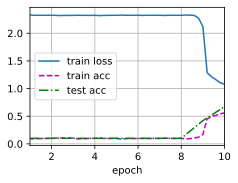

In [84]:
lr, num_epochs = 0.75, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.433, train acc 0.841, test acc 0.825
2478.6 examples/sec on cpu


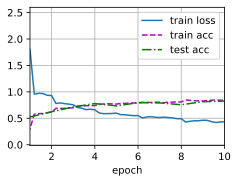

In [85]:
lr, num_epochs = 0.8, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.298, train acc 0.888, test acc 0.855
2288.1 examples/sec on cpu


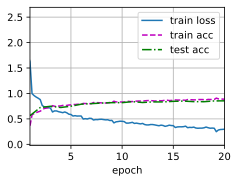

In [88]:
lr, num_epochs = 0.8, 20
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.271, train acc 0.897, test acc 0.831
2357.0 examples/sec on cpu


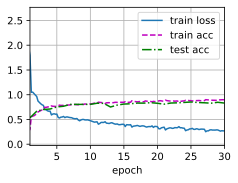

In [89]:
lr, num_epochs = 0.8, 30
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.202, train acc 0.923, test acc 0.846
2485.8 examples/sec on cpu


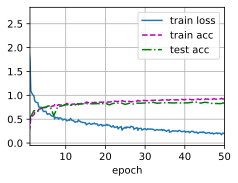

In [90]:
lr, num_epochs = 0.8, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.057, train acc 0.983, test acc 0.824
2612.8 examples/sec on cpu


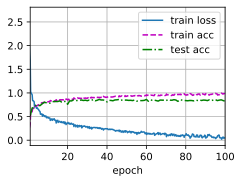

In [91]:
lr, num_epochs = 0.8, 100
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [92]:
#随着学习轮数的提高，准确度上升但有限，且运行时间大幅提高，不妨选择50轮。

In [93]:
#固定学习率和学习轮次，重新调整batch_size

In [94]:
#修改batch_size
batch_size =8
train_iter = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

loss 0.156, train acc 0.939, test acc 0.855
2652.2 examples/sec on cpu


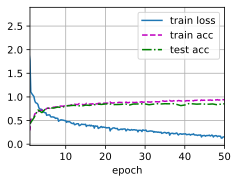

In [95]:
lr, num_epochs = 0.8, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [96]:
#修改batch_size
batch_size =4
train_iter = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

loss 0.241, train acc 0.909, test acc 0.855
1406.5 examples/sec on cpu


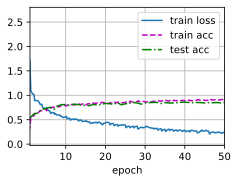

In [97]:
lr, num_epochs = 0.8, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [98]:
#修改batch_size
batch_size =16
train_iter = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

loss 0.287, train acc 0.890, test acc 0.797
4124.6 examples/sec on cpu


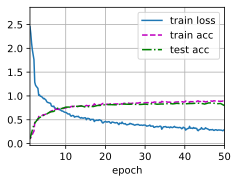

In [99]:
lr, num_epochs = 0.8, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [100]:
#修改batch_size
batch_size =32
train_iter = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

loss 0.373, train acc 0.857, test acc 0.838
5351.0 examples/sec on cpu


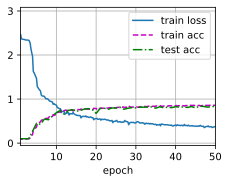

In [101]:
lr, num_epochs = 0.8, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [102]:
#修改batch_size
batch_size =64
train_iter = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

loss 0.511, train acc 0.807, test acc 0.791
5309.9 examples/sec on cpu


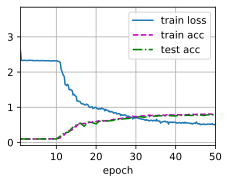

In [103]:
lr, num_epochs = 0.8, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [107]:
#由以上，固定batch_size为8，
#最终参数：
#batch_size=8，lr, num_epochs = 0.8, 50

In [252]:
#修改batch_size
batch_size =8
train_iter = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [109]:
#第二题：构建一个基于 LeNet 的更复杂的网络

In [121]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.157, train acc 0.945, test acc 0.865
2384.5 examples/sec on cpu


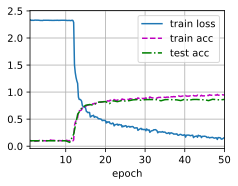

In [122]:
lr, num_epochs = 0.8, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [151]:
#改变卷积窗口大小和输出通道

In [125]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=6, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.195, train acc 0.926, test acc 0.828
2516.6 examples/sec on cpu


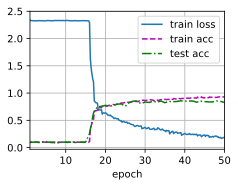

In [126]:
lr, num_epochs = 0.8, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [131]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=4, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.267, train acc 0.897, test acc 0.844
2251.8 examples/sec on cpu


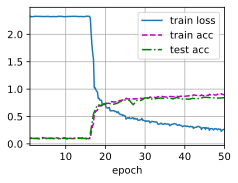

In [132]:
lr, num_epochs = 0.8, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [149]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 20))                                                    

loss 0.122, train acc 0.954, test acc 0.847
2214.6 examples/sec on cpu


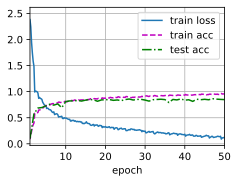

In [150]:
lr, num_epochs = 0.8, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [152]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 30)) 

loss 0.131, train acc 0.953, test acc 0.864
2271.3 examples/sec on cpu


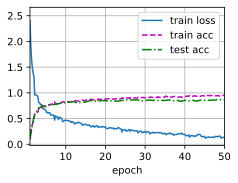

In [153]:
lr, num_epochs = 0.8, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [154]:
#调正卷积层、全连接层数量

In [155]:
net = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(8, 16, kernel_size=3, padding=1), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(32 * 3 * 3, 128), nn.Sigmoid(),
    nn.Linear(128, 64), nn.Sigmoid(),
    nn.Linear(64, 32), nn.Sigmoid(),
    nn.Linear(32, 10)
)

loss 2.328, train acc 0.096, test acc 0.100
1627.9 examples/sec on cpu


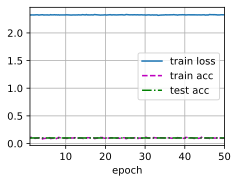

In [156]:
lr, num_epochs = 0.8, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [253]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=3, padding=1), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(32 * 3 * 3, 128), nn.Sigmoid(),
    nn.Linear(128, 64), nn.Sigmoid(),
    nn.Linear(64, 30)
)

loss 2.326, train acc 0.105, test acc 0.100
1795.4 examples/sec on cpu


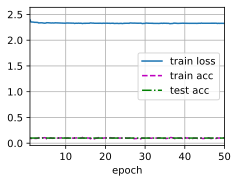

In [168]:
lr, num_epochs = 0.8, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.887, train acc 0.640, test acc 0.654
1525.8 examples/sec on cpu


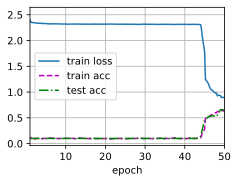

In [254]:
lr, num_epochs = 0.2, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.504, train acc 0.812, test acc 0.792
1248.6 examples/sec on cpu


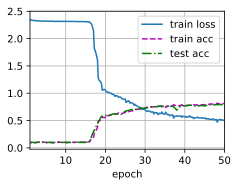

In [255]:
lr, num_epochs = 0.1, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.655, train acc 0.751, test acc 0.737
1350.7 examples/sec on cpu


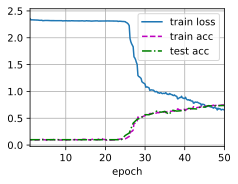

In [256]:
lr, num_epochs = 0.05, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [169]:
#改变激活函数和相应学习率等

In [172]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Tanh(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Tanh(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Tanh(),
    nn.Linear(120, 84), nn.Tanh(),
    nn.Linear(84, 30)) 

loss 0.336, train acc 0.887, test acc 0.803
3017.9 examples/sec on cpu


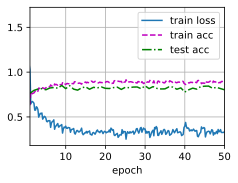

In [173]:
lr, num_epochs = 0.2, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.001, train acc 1.000, test acc 0.857
2540.3 examples/sec on cpu


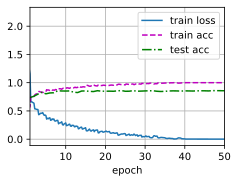

In [174]:
lr, num_epochs = 0.1, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.173, train acc 0.942, test acc 0.830
2514.5 examples/sec on cpu


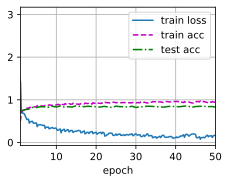

In [175]:
lr, num_epochs = 0.15, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.004, train acc 1.000, test acc 0.867
2501.7 examples/sec on cpu


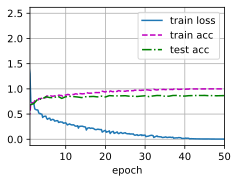

In [176]:
lr, num_epochs = 0.05, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [177]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 30)) 

loss 0.056, train acc 0.980, test acc 0.848
2350.8 examples/sec on cpu


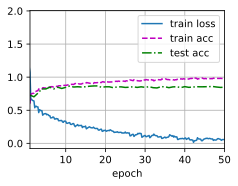

In [178]:
lr, num_epochs = 0.05, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.121, train acc 0.960, test acc 0.855
2440.5 examples/sec on cpu


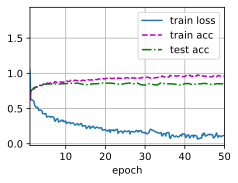

In [179]:
lr, num_epochs = 0.1, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.143, train acc 0.952, test acc 0.847
2328.3 examples/sec on cpu


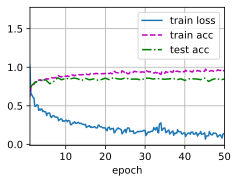

In [180]:
lr, num_epochs = 0.15, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.338, train acc 0.875, test acc 0.808
2407.4 examples/sec on cpu


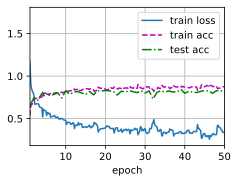

In [181]:
lr, num_epochs = 0.2, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.297, train acc 0.888, test acc 0.820
2337.8 examples/sec on cpu


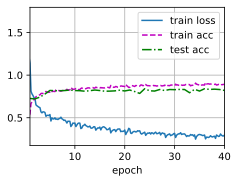

In [182]:
lr, num_epochs = 0.1, 40
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 30)) 

In [ ]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=3, padding=1), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(32 * 3 * 3, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(64, 30)
)

In [ ]:
lr, num_epochs = 0.01, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [183]:
#最终选择的卷积网络为

loss 0.101, train acc 0.969, test acc 0.864
2060.4 examples/sec on cpu


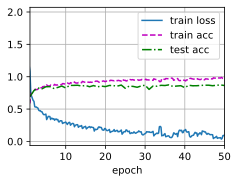

In [184]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 30))
lr, num_epochs = 0.1, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [213]:
#显示不同输入（例如毛衣和外套）时，LeNet 第一个卷积层和第二个卷积层的激活值。

In [210]:
with torch.no_grad():
    sweater_activations_conv1 = net[0](sweater_samples)
    sweater_activations_conv2 = net[3](net[2](net[1](net[0](sweater_samples))))
    coat_activations_conv1 = net[0](coat_samples)
    coat_activations_conv2 = net[3](net[2](net[1](net[0](coat_samples))))

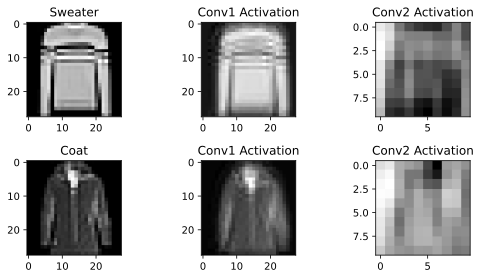

In [212]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

plt.subplot(2, 4, 1)
plt.imshow(sweater_samples[0, 0].squeeze().detach().numpy(), cmap='gray')
plt.title('Sweater')

plt.subplot(2, 4, 2)
plt.imshow(sweater_activations_conv1[0, 0].squeeze().detach().numpy(), cmap='gray')
plt.title('Conv1 Activation')

plt.subplot(2, 4, 3)
plt.imshow(sweater_activations_conv2[0, 0].squeeze().detach().numpy(), cmap='gray')
plt.title('Conv2 Activation')

plt.subplot(2, 4, 5)
plt.imshow(coat_samples[0, 0].squeeze().detach().numpy(), cmap='gray')
plt.title('Coat')

plt.subplot(2, 4, 6)
plt.imshow(coat_activations_conv1[0, 0].squeeze().detach().numpy(), cmap='gray')
plt.title('Conv1 Activation')

plt.subplot(2, 4, 7)
plt.imshow(coat_activations_conv2[0, 0].squeeze().detach().numpy(), cmap='gray')
plt.title('Conv2 Activation')

plt.tight_layout()
plt.show()

In [214]:
#第三题：全量样本训练

In [215]:
batch_size = 256
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

loss 0.185, train acc 0.930, test acc 0.887
7596.4 examples/sec on cpu


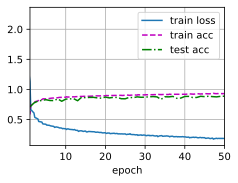

In [217]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 30))
lr, num_epochs = 0.1, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [218]:
#调整batch_size

In [219]:
batch_size = 128
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

loss 0.136, train acc 0.948, test acc 0.892
7364.4 examples/sec on cpu


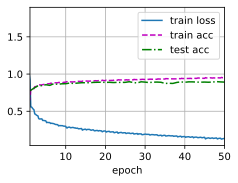

In [220]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 30))
lr, num_epochs = 0.1, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [221]:
batch_size = 64
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

loss 0.094, train acc 0.965, test acc 0.896
2380.6 examples/sec on cpu


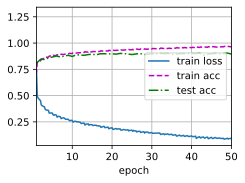

In [222]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 30))
lr, num_epochs = 0.1, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [223]:
batch_size = 32
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

loss 0.079, train acc 0.970, test acc 0.895
5099.8 examples/sec on cpu


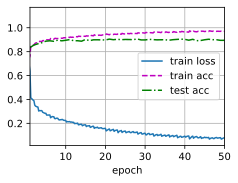

In [224]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 30))
lr, num_epochs = 0.1, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [225]:
batch_size = 16
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

loss 0.109, train acc 0.960, test acc 0.893
3527.3 examples/sec on cpu


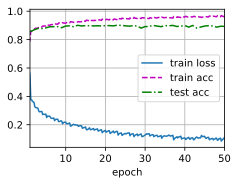

In [226]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 30))
lr, num_epochs = 0.1, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [227]:
batch_size = 8
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

loss 0.173, train acc 0.938, test acc 0.888
2542.7 examples/sec on cpu


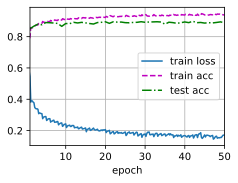

In [228]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 30))
lr, num_epochs = 0.1, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [229]:
batch_size = 512
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

loss 0.235, train acc 0.911, test acc 0.875
7339.2 examples/sec on cpu


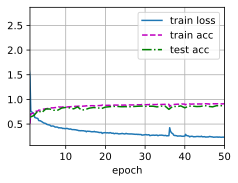

In [230]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 30))
lr, num_epochs = 0.1, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [231]:
#尝试其他网络

In [257]:
batch_size = 32
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [233]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 30)) 

loss 0.109, train acc 0.958, test acc 0.905
4375.2 examples/sec on cpu


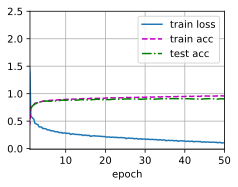

In [234]:
lr, num_epochs = 0.8, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [258]:
net = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(8, 16, kernel_size=3, padding=1), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(32 * 3 * 3, 128), nn.Sigmoid(),
    nn.Linear(128, 64), nn.Sigmoid(),
    nn.Linear(64, 32), nn.Sigmoid(),
    nn.Linear(32, 10)
)

loss 2.303, train acc 0.101, test acc 0.100
3328.5 examples/sec on cpu


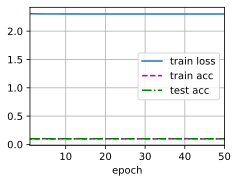

In [259]:
lr, num_epochs = 0.08, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [237]:
net = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(8, 16, kernel_size=3, padding=1), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(32 * 3 * 3, 128), nn.Sigmoid(),
    nn.Linear(128, 64), nn.Sigmoid(),
    nn.Linear(64, 32), nn.Sigmoid(),
    nn.Linear(32, 10)
)

loss 2.303, train acc 0.098, test acc 0.100
162.1 examples/sec on cpu


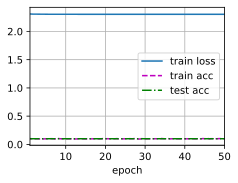

In [238]:
lr, num_epochs = 0.1, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [240]:
#最终选定网络和参数为：

In [241]:
batch_size = 32
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [242]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 30)) 

loss 0.120, train acc 0.955, test acc 0.905
4855.7 examples/sec on cpu


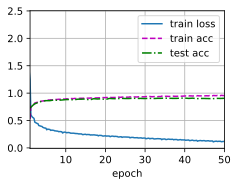

In [243]:
lr, num_epochs = 0.8, 50
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())